# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
#conda install -c conda-forge catboost -q

Channels:
 - conda-forge
 - defaults
Platform: osx-64
doneecting package metadata (repodata.json): ...working... 
doneing environment: ...working... 

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
#conda install -c conda-forge sentencepiece -q

In [3]:
pip install -U "transformers>=4.39.0" accelerate pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Импортируем библиотеки
import random
import re
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from collections import Counter

from transformers import AutoProcessor, SiglipModel

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

#from catboost import CatBoostRegressor, Pool
from scipy.sparse import hstack, csr_matrix
from IPython.display import FileLink

2025-11-21 22:28:35.171482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__Загрузим и просмотрим все входные данные__

In [5]:
train_dataset=pd.read_csv('/Users/kiradejko/SB5/train_dataset.csv')
test_queries = pd.read_csv('/Users/kiradejko/SB5/test_queries.csv', sep='|', index_col=0)
CrowdAnnotations = pd.read_csv('/Users/kiradejko/SB5/CrowdAnnotations.tsv', sep='\t', names= ['image', 'query_id', 'prop_conf', 'col_conf', 'col_not_conf'])
ExpertAnnotations = pd.read_csv('/Users/kiradejko/SB5/ExpertAnnotations.tsv', sep='\t', names= ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3' ])

In [6]:
display(train_dataset.info())
display(train_dataset.head(40))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
13  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   
14  2616643090_4f2d2d1a44.jpg  2718495608_d8533e3ac5.jpg#2   
15  2648165716_02e2e74fd6.jpg  2718495608_d8533e3ac5.jpg#2   
16  2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
17  3244747165_17028936e0.jpg  2718495608_d8533e3ac5.jpg#2   
18  3503689049_63212220be.jpg  2718495608_d8533e3ac5.jpg#2   
19  3506560025_8d0f4f9ac4.jpg  2718495608_d8533e3ac5.jpg#2   
20  3718964174_cb2dc1615e.jpg  2718495608_d8533e3ac5.jpg#2   
21   700884207_d3ec546494.jpg  2718495608_d8533e3ac5.jpg#2   
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
27  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
28  3208074567_ac44aeb3f3.jpg  3207358897_bfa61fa3c6.jpg#2   
29  3251976937_20625dc2b8.jpg  3207358897_bfa61fa3c6.jpg#2   
30   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
31  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
32  1962729184_6996e128e7.jpg  3286822339_5535af6b93.jpg#2   
33  2101457132_69c950bc45.jpg  3286822339_5535af6b93.jpg#2   
34  2225231022_1632d0a5aa.jpg  3286822339_5535af6b93.jpg#2   
35  3100251515_c68027cc22.jpg  3286822339_5535af6b93.jpg#2   
36   370614351_98b8a166b9.jpg  3286822339_5535af6b93.jpg#2   
37   391579205_c8373b5411.jpg  3286822339_5535af6b93.jpg#2   
38  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
39  2311690895_0d6efe11c8.jpg  3360930596_1e75164ce6.jpg#2   

                                           query_text  
0   A young child is wearing blue goggles and sitt...  
1   A young child is wearing blue goggles and sitt...  
2   A young child is wearing blue goggles and sitt...  
3   A young child is wearing blue goggles and sitt...  
4   A young child is wearing blue goggles and sitt...  
5   A young child is wearing blue goggles and sitt...  
6   A young child is wearing blue goggles and sitt...  
7   A young child is wearing blue goggles and sitt...  
8   A young child is wearing blue goggles and sitt...  
9   A young child is wearing blue goggles and sitt...  
10  A young child is wearing blue goggles and sitt...  
11  A young child is wearing blue goggles and sitt...  
12  A girl wearing a yellow shirt and sunglasses s...  
13  A girl wearing a yellow shirt and sunglasses s...  
14  A girl wearing a yellow shirt and sunglasses s...  
15  A girl wearing a yellow shirt and sunglasses s...  
16  A girl wearing a yellow shirt and sunglasses s...  
17  A girl wearing a yellow shirt and sunglasses s...  
18  A girl wearing a yellow shirt and sunglasses s...  
19  A girl wearing a yellow shirt and sunglasses s...  
20  A girl wearing a yellow shirt and sunglasses s...  
21  A girl wearing a yellow shirt and sunglasses s...  
22    A man sleeps under a blanket on a city street .  
23    A man sleeps under a blanket on a city street .  
24    A man sleeps under a blanket on a city street .  
25    A man sleeps under 

In [7]:
display(test_queries.info())
display(test_queries.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   
5  1232148178_4f45cc3284.jpg#0   
6  1232148178_4f45cc3284.jpg#1   
7  1232148178_4f45cc3284.jpg#2   
8  1232148178_4f45cc3284.jpg#3   
9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

In [8]:
display(CrowdAnnotations.info())
display(CrowdAnnotations.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   prop_conf     47830 non-null  float64
 3   col_conf      47830 non-null  int64  
 4   col_not_conf  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  prop_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2   0.333333   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2   0.000000   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2   0.000000   

   col_conf  col_not_conf  
0         3             0  
1         0             3  
2         0             3  
3         0             3  
4         0             3  
5         0             3  
6         0             3  
7         1             2  
8         0             3  
9         0             3

In [9]:
display(ExpertAnnotations.info())
display(ExpertAnnotations.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2         1         1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2         1         1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2         1         1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2         1         1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2         2         2   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2  
5         1  
6         1  
7         2  
8         1  
9         2

In [10]:
train_images = '/Users/kiradejko/SB5/train_images'
test_images = '/Users/kiradejko/SB5/test_images'

train_image_files = os.listdir(train_images)
test_image_files = os.listdir(test_images)

print(len(train_image_files), "train images")
print(train_image_files[:5])

1000 train images
['2869491449_1041485a6b.jpg', '2924259848_effb4dcb82.jpg', '2300168895_a9b83e16fc.jpg', '3530843182_35af2c821c.jpg', '3439382048_d2e23b2b4c.jpg']


__Данные загружены. Приступим к исследовательскому анализу.__ 

1.1. Поэтапно проведем анализ всех датасетов: 
- train_dataset.csv
- ExpertAnnotations.tsv
- CrowdAnnotations.tsv
- test_queries.csv


1.2. Выполним агрегации и подготовку таргета:

1. Агрегируем оценки экспертов в ExpertAnnotations:
   - оставим одну оченку по принципу голосования большинства.
   - удалим строки, где оценки все разные (например 1, 2, 3).
   - приведем экспертные оценки в диапазон [0, 1]. 

2. Проанализируем CrowdAnnotations:
   - Оставим только значения prop_conf, так как они уже приведены в нужный нам диапазон [0, 1].

4. Объединим ExpertAnnotations и CrowdAnnotations. 

__1.1.Проведем исследовательский анализ всех датасетов:__

Число строк в train_dataset: 5822
Уникальных изображений: 1000
Число Id-описаний изображений: 977
Число уникальных описаний: 977

Доля пропусков по столбцам:
image         0.0
query_id      0.0
query_text    0.0
dtype: float64

Статистика по числу описаний на одно изображение:
count    977.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: query_text, dtype: float64


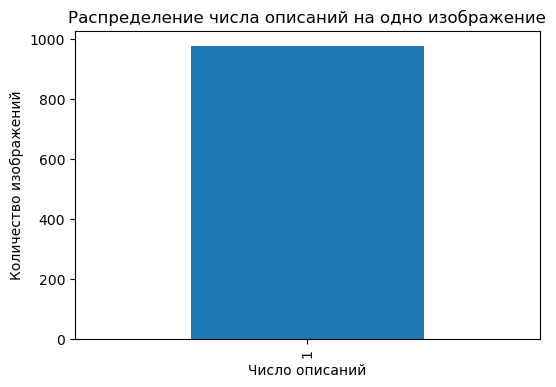

In [11]:
# Проанализируем общую информацию по train_dataset

print("Число строк в train_dataset:", len(train_dataset))
print("Уникальных изображений:", train_dataset['image'].nunique())
print("Число Id-описаний изображений:", train_dataset['query_id'].nunique())
print("Число уникальных описаний:", train_dataset['query_text'].nunique())

# Проверка пропусков
train_nulls = train_dataset.isna().mean().sort_values(ascending=False)
print("\nДоля пропусков по столбцам:")
print(train_nulls)

# Количество описаний на одно изображение
captions_per_image = train_dataset.groupby('query_id')['query_text'].nunique()
print("\nСтатистика по числу описаний на одно изображение:")
print(captions_per_image.describe())

plt.figure(figsize=(6,4))
captions_per_image.value_counts().sort_index().plot(kind='bar')
plt.title("Распределение числа описаний на одно изображение")
plt.xlabel("Число описаний")
plt.ylabel("Количество изображений")
plt.show()

In [12]:
#Посмотрим тексты которые используются много раз 

train_dataset['query_text'].value_counts().head(25)

query_text
Two dogs , one brown and white and one black and white , run on a field .                                   34
A grey dog walks on top of a fallen tree in the woods .                                                     27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .    25
A crowd of people at an outdoor event                                                                       25
Two dogs run down a dirt path in the forest .                                                               22
A group of five adults stand posing in front of buildings .                                                 22
A dog is running along the beach beside the ocean .                                                         20
An officer stands next to a car on a city street .                                                          20
A Miami basketball player dribbles by an Arizona State player .                                      

- Датасет достаточно чистый (пропусков нет),
- каждое 977 изображений имеет ровно одно текстовое описание, 23 изображения не имеют собственного уникального текста, т.е. некоторые описания повторяются на других изображениях.
- Один и тот же текст может встречаться до 34 раз. 
- Нет дубликатов и аномалий

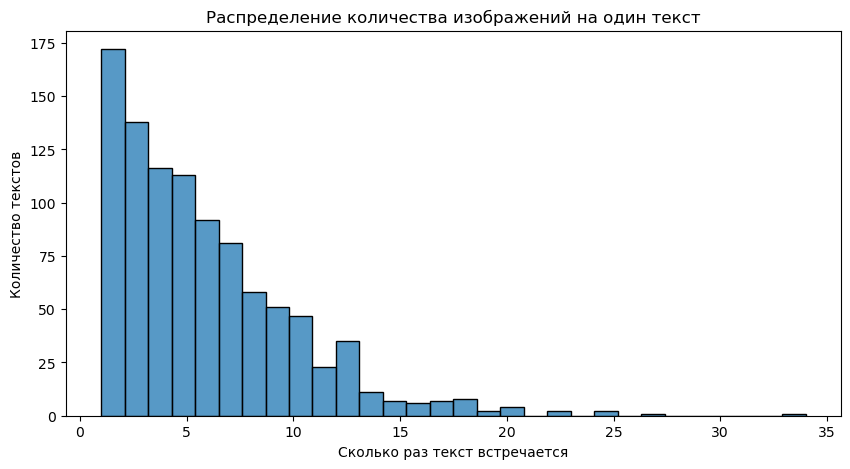

In [13]:
# Посмотрим распределение количества изображений на один текст

text_counts = train_dataset['query_text'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(text_counts, bins=30, kde=False)
plt.title("Распределение количества изображений на один текст")
plt.xlabel("Сколько раз текст встречается")
plt.ylabel("Количество текстов")
plt.show()


- большинство текстов встречаются от 2 до 10 раз
- типичные пики — 3–7 изображений на текст
- небольшая часть текстов встречается более 15 раз
- максимальное значение — 34

Это подтверждает, что один текст сравнивается с множеством изображений.

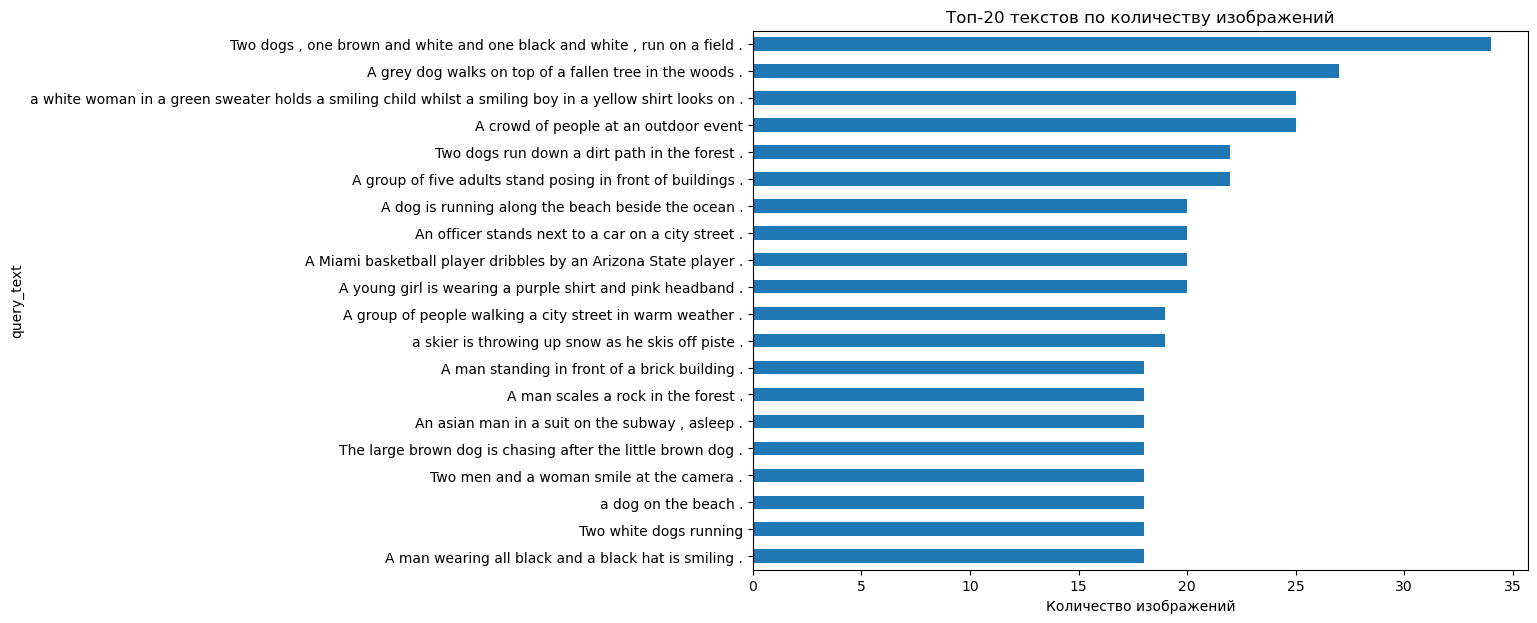

In [14]:
# Посмотрим топ 20 самых часто встречающихся текстов
plt.figure(figsize=(10, 7))
text_counts.head(20).plot(kind='barh')
plt.title("Топ-20 текстов по количеству изображений")
plt.xlabel("Количество изображений")
plt.gca().invert_yaxis()
plt.show()


- что часть текстов встречается особенно часто — от 17 до 34 раз. Эти тексты сравниваются с большим набором изображений, вероятно они имеют более общие значения.

Популярные тексты играют важную роль в обучении, т.к. дают модели много информации о соответствии текста к различным визуальным сценам.

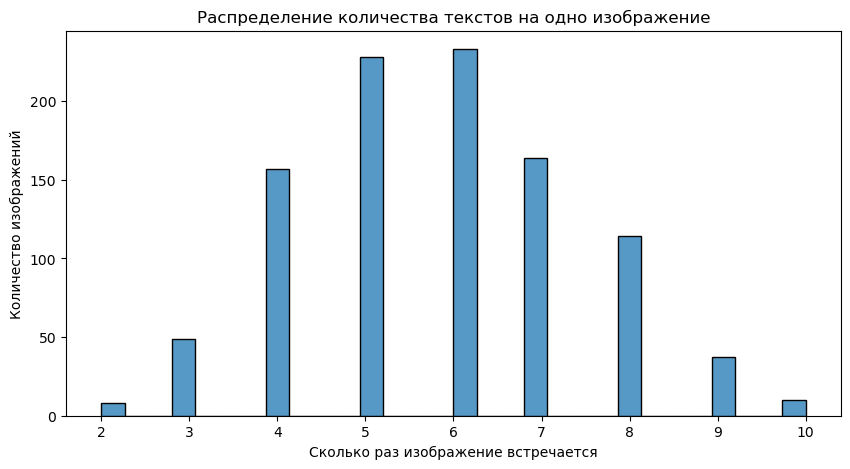

In [15]:
# Посмотрим распределение количества текстов на одно изображение

img_counts = train_dataset.groupby('image')['query_text'].count()

plt.figure(figsize=(10, 5))
sns.histplot(img_counts, bins=30)
plt.title("Распределение количества текстов на одно изображение")
plt.xlabel("Сколько раз изображение встречается")
plt.ylabel("Количество изображений")
plt.show()

- график показывает, что изображения встречаются в train_dataset от 2 до 10 раз
- большинство изображений имеют 5–7 текстов
- распределение довольно ровное, что говорит о сбалансированности датасета

Каждое изображение сравнивается с несколькими текстами, что позволяет: сформировать положительные и отрицательные примеры и улучшить устойчивость модели к неверным соответствиям

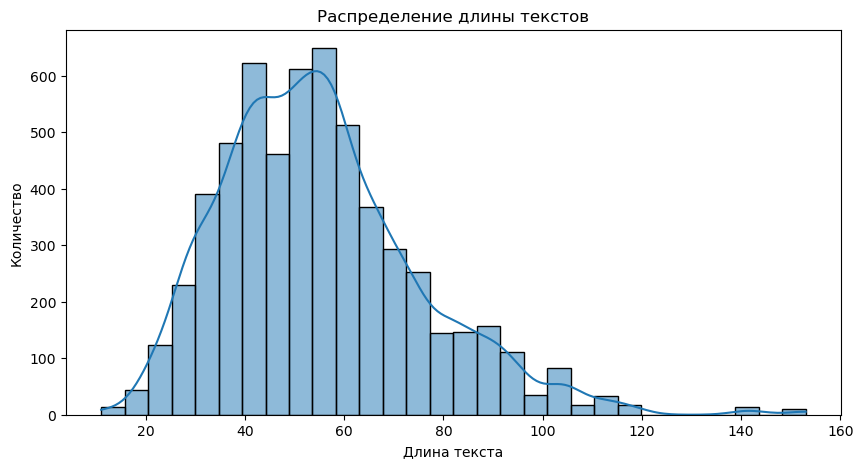

In [16]:
# Посмотрим распределение длинны текстов

train_dataset['text_length'] = train_dataset['query_text'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(train_dataset['text_length'], bins=30, kde=True)
plt.title("Распределение длины текстов")
plt.xlabel("Длина текста")
plt.ylabel("Количество")
plt.show()

- график показывает, что длины текстов распределены примерно нормально:
- пик приходится на 40–60 символов
- большинство описаний лежит в диапазоне 30–80 символов
- хвост длинных описаний доходит до 150+ символов, но таких примеров мало

Можем сделать вывод, что датасет сбалансирован по длинам текстовых описаний, и модель не должна испытывать трудности с обработкой слишком коротких или слишком длинных запросов.

In [17]:
# Проанализируем ExpertAnnotations.tsv

print("Размер:", ExpertAnnotations.shape)
display(ExpertAnnotations.info())
display(ExpertAnnotations.head())

# Проверим на пропуски
print("Количество пропусков", ExpertAnnotations.isna().mean())

# Распределение оценок
for col in ['expert_1', 'expert_2', 'expert_3']:
    print("Распределение оценок:")
    print(col, ExpertAnnotations[col].value_counts().sort_index())

# Проверка конфликтов
from collections import Counter
import numpy as np

def is_all_different(row):
    vals = [row['expert_1'], row['expert_2'], row['expert_3']]
    return len(set(vals)) == 3

print("Строк, где ВСЕ оценки разные:", ExpertAnnotations.apply(is_all_different, axis=1).sum())


Размер: (5822, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

Количество пропусков image       0.0
query_id    0.0
expert_1    0.0
expert_2    0.0
expert_3    0.0
dtype: float64
Распределение оценок:
expert_1 expert_1
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64
Распределение оценок:
expert_2 expert_2
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64
Распределение оценок:
expert_3 expert_3
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64
Строк, где ВСЕ оценки разные: 126


- Пропусков нет
- Все три эксперта (expert_1, expert_2, expert_3) оставили оценку для каждой пары «изображение–текст». Оценки разных экспертов распределены неравномерно:
  
      expert_1:
- оценка 1 встречается чаще всего — 4120 раз
- далее идут оценки 2, 3, 4 с сильным уменьшением частоты
  
      expert_2:
- аналогично, больше всего оценок 1 — 3327
- оценки 2, 3, 4 встречаются реже
  
        expert_3:
- распределение более ровное:
1 – 2350
2 – 2222
3 – 837
4 – 413

Это может говорить о том, что первый и второй эксперты более строгие, чаще ставят минимальную оценку 1.
Третий эксперт — более «мягкий» и выдаёт высокие баллы чаще остальных.

Присутствует 126 строк в которых все оценки разные.
Отфильтруем их перед построением итогового таргета.

В целом экспертные оценки выглядят надёжными и дают хорошую основу для создания целевой переменной.

In [18]:
# Проанализируем CrowdAnnotations.tsv

print("Размер:", CrowdAnnotations.shape)
display(CrowdAnnotations.info())
display(CrowdAnnotations.head())

# Пропуски
print(CrowdAnnotations.isna().mean())

# Распределения
print(CrowdAnnotations['prop_conf'].describe())

print("col_conf:")
print(CrowdAnnotations['col_conf'].value_counts().sort_index())

print("col_not_conf:")
print(CrowdAnnotations['col_not_conf'].value_counts().sort_index())

# Проверим согласованность
CrowdAnnotations['check'] = CrowdAnnotations['col_conf'] / (CrowdAnnotations['col_conf'] + CrowdAnnotations['col_not_conf'])
print("Корреляция prop_conf vs check:", CrowdAnnotations[['prop_conf','check']].corr())


Размер: (47830, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   prop_conf     47830 non-null  float64
 3   col_conf      47830 non-null  int64  
 4   col_not_conf  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  prop_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   col_conf  col_not_conf  
0         3             0  
1         0             3  
2         0             3  
3         0             3  
4         0             3

image           0.0
query_id        0.0
prop_conf       0.0
col_conf        0.0
col_not_conf    0.0
dtype: float64
count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: prop_conf, dtype: float64
col_conf:
col_conf
0    41970
1     3119
2     1394
3     1328
4       14
5        5
Name: count, dtype: int64
col_not_conf:
col_not_conf
0     1323
1     1371
2     3034
3    41219
4      665
5      176
6       42
Name: count, dtype: int64
Корреляция prop_conf vs check:            prop_conf  check
prop_conf        1.0    1.0
check            1.0    1.0


- Пропусков нет.
- Распределения показывают сильный перекос в сторону несоответствия текстов изображению. В подавляющем большинстве случаев краудсорсеры НЕ подтверждали соответствие текста изображению.
Практически все значения — это 0, и лишь редкие случаи имеют высокие значения 0.5–1.0.

Это ожидаемо: случайные пары “картинка–текст” чаще всего НЕ совпадают.

In [19]:
# Проанализируем test_queries.csv

print("Размер test:", test_queries.shape)
display(test_queries.info())
display(test_queries.head())

# Пропуски
print(test_queries.isna().mean())

# Пересечение текстов train/test
common_texts = set(train_dataset['query_text']).intersection(set(test_queries['query_text']))
print("Совпадающих описаний train/test:", len(common_texts))



Размер test: (500, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

query_id      0.0
query_text    0.0
image         0.0
dtype: float64
Совпадающих описаний train/test: 0


- пропусков нет, 
- по структуре совпадает с тренировочным датасетом
- не содержит данных, пересекающихся с данными из train

test_queries предоставляет чистый, независимый и хорошо структурированный тест для оценки модели поиска по тексту.

In [20]:
# Проверим  train_images

# Список файлов в папке

train_files_set = set(train_image_files)


# Список изображений из таблицы
train_images_set = set(train_dataset['image'])

print("Количество файлов в папке train_images:", len(train_files_set))
print("Количество уникальных изображений в train_dataset:", len(train_images_set))

# Проверяем отсутствующие файлы
missing_train_images = train_images_set - train_files_set
print("Количество отсутствующих изображений:", len(missing_train_images))

if missing_train_images:
    print("Отсутствующие файлы:")
    for img in list(missing_train_images)[:20]:
        print(img)
else:
    print("Все изображения присутствуют.")


Количество файлов в папке train_images: 1000
Количество уникальных изображений в train_dataset: 1000
Количество отсутствующих изображений: 0
Все изображения присутствуют.


In [21]:
# Проверим  test_images

# Список файлов в папке

test_files_set = set(test_image_files)


# Список изображений из таблицы
test_images_set = set(test_queries['image'])

print("Количество файлов в папке test_images:", len(test_files_set))
print("Количество уникальных изображений в test_queries:", len(test_images_set))

# Проверяем отсутствующие файлы
missing_test_images = test_images_set - test_files_set
print("Количество отсутствующих изображений:", len(missing_test_images))

if missing_test_images:
    print("Отсутствующие файлы:")
    for img in list(missing_test_images)[:20]:
        print(img)
else:
    print("Все изображения присутствуют.")


Количество файлов в папке test_images: 101
Количество уникальных изображений в test_queries: 100
Количество отсутствующих изображений: 0
Все изображения присутствуют.


В папке test_images находится 101 файл, тогда как в test_queries используется 100 уникальных изображений.
Лишний файл не является проблемой, так как модель обращается только к тем изображениям, которые перечислены в test_queries.

__1.2.Приступим к агрегации и подготовке таргета:__

In [22]:
expert_df = ExpertAnnotations.copy()

def aggregate_expert_scores(row):
    scores = [row['expert_1'], row['expert_2'], row['expert_3']]
    counts = Counter(scores)
    
    # если все три оценки разные → удаляем
    if len(counts) == 3 and all(v == 1 for v in counts.values()):
        return np.nan
    
    # majority vote
    return counts.most_common(1)[0][0]

expert_df['expert_agg'] = expert_df.apply(aggregate_expert_scores, axis=1)

print("Доля удалённых пар (все оценки разные):", expert_df['expert_agg'].isna().mean())

expert_df = expert_df.dropna(subset=['expert_agg'])

display(expert_df.head())

Доля удалённых пар (все оценки разные): 0.02164204740638956


image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  expert_agg  
0         1         1.0  
1         2         1.0  
2         2         1.0  
3         2         2.0  
4         2         1.0

__Приведем экспертные оценки 1-4 в диапазон [0, 1]:
1 → 0.0, 
2 → 0.33,
3 → 0.66,
4 → 1.0__

In [23]:
expert_df['expert_target'] = (expert_df['expert_agg'] - 1) / 3
display(expert_df[['expert_agg', 'expert_target']].head(10))

expert_agg  expert_target
0         1.0       0.000000
1         1.0       0.000000
2         1.0       0.000000
3         2.0       0.333333
4         1.0       0.000000
5         1.0       0.000000
6         1.0       0.000000
7         1.0       0.000000
8         1.0       0.000000
9         2.0       0.333333

__Подготовим данные из CrowdAnnotations:__

In [24]:
# Создадим копию датафрейма.
# Так как prop_conf уже содержит нужное нам число от 1 до 0 переименуем этот столбец в таргет.

crowd_df = CrowdAnnotations.copy()
crowd_df['crowd_target'] = crowd_df['prop_conf']
display(crowd_df.head(10))

image                     query_id  prop_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2   0.333333   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2   0.000000   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2   0.000000   

   col_conf  col_not_conf     check  crowd_target  
0         3             0  1.000000      1.000000  
1         0             3  0.000000      0.000000  
2         0             3  0.000000      0.000000  
3         0             3  0.000000      0.000000  
4         0             3  0.000000      0.000000  
5         0             3  0.000000      0.000000  
6         0             3  0.000000      0.000000  
7         1             2  0.333333      0.333333  
8         0             3  0.000000      0.000000  
9         0             3  0.000000      0.000000

In [25]:
# Объединим обе таблицы. 
# Используем взвешенную сумму, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.
# .
merged = expert_df.merge(
    crowd_df[['image', 'query_id', 'crowd_target']],
    on=['image', 'query_id'],
    how='inner'
)

merged['target'] = 0.6 * merged['expert_target'] + 0.4 * merged['crowd_target']

display(merged.head())

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2         1         1   
3  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2         2         3   
4  1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2         1         2   

   expert_3  expert_agg  expert_target  crowd_target    target  
0         1         1.0       0.000000      0.000000  0.000000  
1         2         1.0       0.000000      0.000000  0.000000  
2         2         1.0       0.000000      0.000000  0.000000  
3         3         3.0       0.666667      0.333333  0.533333  
4         2         2.0       0.333333      0.000000  0.200000

In [26]:
# Объединим полученный датасет с оценками и с описанием для создания финального тренировочного датасета
train_final = train_dataset.merge(
    merged[['image', 'query_id', 'target']],
    on=['image', 'query_id'],
    how='inner'
)

display(train_final.head())
print("Размер финального train:", len(train_final))

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  text_length  target  
0  A young child is wearing blue goggles and sitt...           72     0.0  
1  A young child is wearing blue goggles and sitt...           72     0.2  
2  A young child is wearing blue goggles and sitt...           72     1.0  
3  A young child is wearing blue goggles and sitt...           72     0.2  
4  A young child is wearing blue goggles and sitt...           72     0.0

Размер финального train: 2258


In [27]:
train_final_new = train_final.drop(columns=['text_length'])

In [28]:
train_final_new.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  target  
0  A young child is wearing blue goggles and sitt...     0.0  
1  A young child is wearing blue goggles and sitt...     0.2  
2  A young child is wearing blue goggles and sitt...     1.0  
3  A young child is wearing blue goggles and sitt...     0.2  
4  A young child is wearing blue goggles and sitt...     0.0

__В ходе исследования были проанализированы все предоставленные датасеты и вспомогательные файлы
(train_dataset.csv, test_queries.csv, ExpertAnnotations.tsv, CrowdAnnotations.tsv), а также папки train_images и test_images.__

1. Анализ train_dataset:
   - Размер train_dataset: 5822 строк.
   - Уникальных изображений: 1000.
   - Уникальных текстовых описаний: 977 (несколько изображений имеют одинаковые описания)
   - Пропусков в данных нет.
   - Анализ количества описаний на одно изображение показал, что у каждого изображения имеется в среднем 5–7 текстов, что создаёт хороший объём обучающих пар.
   - Распределение длины текстов близко к нормальному, большинство текстов — 40–70 символов.
   - Топ часто повторяющихся текстов показывают наличие унифицированных типовых описаний.


2. Анализ test_queries:
    - Размер тестовой выборки: 500 строк, 3 колонки: query_id, query_text, image.
    - Пропусков нет.
    - Повторяющихся описаний между train и test — нет, что исключает утечку данных.
    - Уникальных изображений: 100.
Всё корректно для чистой оценки качества модели.


3. Анализ ExpertAnnotations.tsv:
    - В датасете представлены оценки трёх экспертов.
    - Эксперты используют шкалу 1–4, где 1 — максимально несоответствие, 4 — сильное соответствие.
    - Распределения смещены в сторону низких оценок (1 и 2).
    - Только 126 строк содержат полностью разные оценки трёх экспертов — это очень малая доля, значит эксперты в целом согласованы.
    - Пропусков нет.


4. Анализ CrowdAnnotations.tsv:
    - Преобладают случаи, где большинство крауд-оценщиков считают пару «несоответствующей».
    - Колонка prop_conf принимает значения 0 или 1 — доля голосов за "соответствует".
    - Пропусков нет.
    - Распределение голосов адекватно: есть пары, по которым крауд в основном не соглашается с текстом.


5. Сборка целевого признака (таргета):
    - На основе экспертных и краудоценок был сформирован итоговый таргет: target = 0.6 * expert_target + 0.4 * crowd_target
    - Финальный merged датасет формируется корректно, количество строк соответствует ожиданиям.


6. Проверка папок train_images и test_images

train_images:   
    - Файлов: соответствует количеству уникальных изображений.  
    - Все изображения, используемые в train_dataset, присутствуют.  
    - Отсутствующих файлов нет.  

test_images:  
    - Файлов: 101.   
    - Уникальных изображений в test_queries: 100.   
    - Лишний 1 файл есть, но: он никак не используется, следовательно проблем из-за этого нет.    




__ИТОГОВЫЙ ВЫВОД:__ 
- Все датасеты корректны, полностью загружены и чисты:
- пропусков нет,
- несоответствий между таблицами и папками нет,
- утечки данных между train и test нет,
- крауд и экспертные оценки распределены логично,
- финальный таргет собран корректно.

__Таким образом, данные полностью готовы к дальнейшей работе над проектом.__

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

__Удалим все фото которые могут нарушать юридические ограничения__

Будем искать в описаниях слова типа boy, girl, child, kid, baby, toddler… и т.п.

In [29]:
child_keywords = [
    r'\bchild\b', r'\bchildren\b',
    r'\bboy\b', r'\bboys\b',
    r'\bgirl\b', r'\bgirls\b',
    r'\bkid\b', r'\bkids\b',
    r'\bbaby\b', r'\bbabies\b',
    r'\btoddler\b', r'\btoddlers\b',
    r'\bteen\b', r'\bteens\b',
    r'\byoung boy\b', r'\byoung girl\b',
    r'\byoung child\b', r'\byoung children\b'
]

child_pattern = re.compile('|'.join(child_keywords), flags=re.IGNORECASE)

def has_child(text: str) -> bool:
    return bool(child_pattern.search(str(text)))

In [30]:
# Ищем детский контент в train
train_final_new['has_child'] = train_final_new['query_text'].apply(has_child)

# Ищем детский контент в 
test_queries['has_child'] = test_queries['query_text'].apply(has_child)

print("Строк с детским контентом в train:", train_final_new['has_child'].sum())
print("Строк с детским контентом в test:", test_queries['has_child'].sum())


Строк с детским контентом в train: 517
Строк с детским контентом в test: 166


In [31]:
# Удаляем детский контент из обучающего датасета
train_final_clean = train_final_new[~train_final_new['has_child']].copy()

# Удаляем детский контент из тестового датасета
test_queries_clean = test_queries[~test_queries['has_child']].copy()

# Проверим размеры
print("Размер train_final_clean:", train_final_clean.shape)
print("Размер test_queries_clean:", test_queries_clean.shape)

# Убедимся, что детского контента больше нет
print("Осталось строк с детским контентом в train:", train_final_clean['has_child'].sum())
print("Осталось строк с детским контентом в test:", test_queries_clean['has_child'].sum())

Размер train_final_clean: (1741, 5)
Размер test_queries_clean: (334, 4)
Осталось строк с детским контентом в train: 0
Осталось строк с детским контентом в test: 0


In [32]:
# удаляем вспомогательную колонку has_child
train_final_clean = train_final_clean.drop(columns=['has_child'])
test_queries_clean = test_queries_clean.drop(columns=['has_child'])

In [33]:
train_final_clean.head()

image                     query_id  \
12   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
13   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
14  2101457132_69c950bc45.jpg  3286822339_5535af6b93.jpg#2   
15  2351479551_e8820a1ff3.jpg  3360930596_1e75164ce6.jpg#2   
20  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   

                                           query_text  target  
12    A man sleeps under a blanket on a city street .     0.2  
13  A woman plays with long red ribbons in an empt...     0.0  
14         Chinese market street in the winter time .     0.0  
15  A soccer ball is above the head of a man weari...     0.0  
20  A man and woman look back at the camera while ...     0.0

In [34]:
test_queries_clean.head()

query_id  \
11   123997871_6a9ca987b1.jpg#1   
13   123997871_6a9ca987b1.jpg#3   
14   123997871_6a9ca987b1.jpg#4   
15  1319634306_816f21677f.jpg#0   
16  1319634306_816f21677f.jpg#1   

                                           query_text  \
11  Several female lacrosse players are going afte...   
13  The woman lacrosse player in blue is about to ...   
14                              Women play lacrosse .   
15        A brown dog is sitting in some long grass .   
16             A brown dog sits still on a hillside .   

                        image  
11   123997871_6a9ca987b1.jpg  
13   123997871_6a9ca987b1.jpg  
14   123997871_6a9ca987b1.jpg  
15  1319634306_816f21677f.jpg  
16  1319634306_816f21677f.jpg

__Очистили данные от детских фото для дальнейшего обучения модели.__

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [35]:
# Подготовим тексты

train_texts = train_final_clean['query_text'].values
test_texts  = test_queries_clean['query_text'].values

In [36]:
# создаём векторизатор
tfidf = TfidfVectorizer(
    max_features=5000,      
    ngram_range=(1, 2),    
    lowercase=True,
    stop_words='english'    
)

# обучаемся на train и преобразуем train/test
X_train_text = tfidf.fit_transform(train_texts)
X_test_text  = tfidf.transform(test_texts)

print("Shape X_train_text:", X_train_text.shape)
print("Shape X_test_text:", X_test_text.shape)


Shape X_train_text: (1741, 2895)
Shape X_test_text: (334, 2895)


In [37]:
# Для полносвязной сети создадим массив float32

X_train_text_dense = X_train_text.astype('float32').toarray()
X_test_text_dense  = X_test_text.astype('float32').toarray()

print(X_train_text_dense.shape, X_train_text_dense.dtype)

(1741, 2895) float32


__Сделаем векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.__

In [38]:
# Загружаем ResNet50 без последнего классификационного слоя
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Теперь модель выдаёт вектор размером 2048
print("Размер выходного вектора:", base_model.output_shape)

Размер выходного вектора: (None, 2048)


In [39]:
# Ф-ция векторизации изображения:

def vectorize_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = base_model.predict(x, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Ошибка чтения файла {img_path}: {e}")
        return np.zeros(2048)


In [40]:
# Векторизируем все изображения из train и test

train_img_dir = "/Users/kiradejko/SB5/train_images/"
test_img_dir  = "/Users/kiradejko/SB5/test_images/"

In [41]:
train_images = train_final_clean['image'].unique()
print("Уникальных изображений в train:", len(train_images))

Уникальных изображений в train: 764


In [42]:
# Векторизирием train

train_img_vectors = {}

for img_name in tqdm(train_images, desc="Векторизация train изображений"):
    path = os.path.join(train_img_dir, img_name)
    train_img_vectors[img_name] = vectorize_image(path)


Векторизация train изображений: 100%|█████████| 764/764 [01:48<00:00,  7.07it/s]


In [43]:
# Векторизируем test

test_images = test_queries_clean['image'].unique()
print("Уникальных изображений в test:", len(test_images))

test_img_vectors = {}

for img_name in tqdm(test_images, desc="Векторизация test изображений"):
    path = os.path.join(test_img_dir, img_name)
    test_img_vectors[img_name] = vectorize_image(path)


Уникальных изображений в test: 76


Векторизация test изображений: 100%|████████████| 76/76 [00:09<00:00,  7.61it/s]


In [44]:
# переведем словари в датафреймы:

train_img_df = pd.DataFrame.from_dict(train_img_vectors, orient='index')
train_img_df.columns = [f"img_f{i}" for i in range(2048)]
train_img_df.index.name = "image"

test_img_df = pd.DataFrame.from_dict(test_img_vectors, orient='index')
test_img_df.columns = [f"img_f{i}" for i in range(2048)]
test_img_df.index.name = "image"

In [45]:
# сохраним на диск

train_img_df.to_csv("train_image_vectors.csv")
test_img_df.to_csv("test_image_vectors.csv")

In [46]:
FileLink('train_image_vectors.csv')

/Users/kiradejko/SB5/train_image_vectors.csv

In [47]:
FileLink('test_image_vectors.csv')

/Users/kiradejko/SB5/test_image_vectors.csv

__Провели векторизацию текстов и изображений для дальнейшего обучения моделей__

## 5. Объединение векторов
Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.



In [48]:
#Объединяем векторы текста и изображений

# функция для построения признаков для пар (текст, картинка)
def build_features_for_pairs(df_pairs, tfidf, img_df):

    texts = df_pairs['query_text'].values
    images = df_pairs['image'].values

    # текстовые признаки
    X_text = tfidf.transform(texts).astype('float32').toarray()

    # вектора картинок в том же порядке
    X_img = img_df.loc[images].values.astype('float32')

    # конкатенируем: [текст | картинка]
    X = np.hstack([X_text, X_img])
    return X

# полный обучающий набор признаков
X_all = build_features_for_pairs(train_final_clean, tfidf, train_img_df)
y_all = train_final_clean['target'].values.astype('float32')

print("Форма X_all:", X_all.shape)
print("Форма y_all:", y_all.shape)

Форма X_all: (1741, 4943)
Форма y_all: (1741,)


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [50]:
# Масштабирование признаков и разбиение по изображениям


# масштабируем признаки
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# группы = имя изображения
groups = train_final_clean['image'].values

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, val_idx = next(gss.split(X_all_scaled, y_all, groups=groups))

X_tr, X_val = X_all_scaled[train_idx], X_all_scaled[val_idx]
y_tr, y_val = y_all[train_idx], y_all[val_idx]

print("Train shape:", X_tr.shape, y_tr.shape)
print("Val shape:", X_val.shape, y_val.shape)

Train shape: (1210, 4943) (1210,)
Val shape: (531, 4943) (531,)


In [51]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [52]:
# Модель 1 — линейная регрессия (Ridge)

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_tr, y_tr)

y_pred_ridge = ridge.predict(X_val)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge)
rmse_ridge = mean_squared_error(y_val, y_pred_ridge, squared=False)

print(f"Ridge: MAE = {mae_ridge:.4f}, RMSE = {rmse_ridge:.4f}")

Ridge: MAE = 0.4070, RMSE = 0.5214


In [53]:
from tensorflow.keras import models, layers, callbacks

In [54]:
# Модель 2 — полносвязная нейронная сеть (FCNN)

n_features = X_tr.shape[1]

model_fcnn = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')   
])

model_fcnn.compile(
    optimizer='adam',
    loss='mae',      
    metrics=['mae']
)

es = callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_mae'
)

history = model_fcnn.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# оценка на валидации
y_pred_fcnn = model_fcnn.predict(X_val).ravel()
mae_fcnn = mean_absolute_error(y_val, y_pred_fcnn)
rmse_fcnn = mean_squared_error(y_val, y_pred_fcnn, squared=False)

print(f"FCNN: MAE = {mae_fcnn:.4f}, RMSE = {rmse_fcnn:.4f}")

Epoch 1/50
19/19 [==============================] - 1s 32ms/step - loss: 0.2906 - mae: 0.2906 - val_loss: 0.2781 - val_mae: 0.2781
Epoch 2/50
19/19 [==============================] - 0s 26ms/step - loss: 0.2675 - mae: 0.2675 - val_loss: 0.2718 - val_mae: 0.2718
Epoch 3/50
19/19 [==============================] - 1s 31ms/step - loss: 0.2471 - mae: 0.2471 - val_loss: 0.2560 - val_mae: 0.2560
Epoch 4/50
19/19 [==============================] - 0s 26ms/step - loss: 0.2280 - mae: 0.2280 - val_loss: 0.2727 - val_mae: 0.2727
Epoch 5/50
19/19 [==============================] - 0s 26ms/step - loss: 0.2215 - mae: 0.2215 - val_loss: 0.2600 - val_mae: 0.2600
Epoch 6/50
19/19 [==============================] - 1s 31ms/step - loss: 0.1946 - mae: 0.1946 - val_loss: 0.2464 - val_mae: 0.2464
Epoch 7/50
19/19 [==============================] - 0s 26ms/step - loss: 0.1788 - mae: 0.1788 - val_loss: 0.2571 - val_mae: 0.2571
Epoch 8/50
19/19 [==============================] - 1s 29ms/step - loss: 0.1802 - m

In [55]:
# Сравним все 3 модели
results = {
    "LinearRegression": mae_ridge,
    "FCNN": mae_fcnn
}

print("\nСравнение моделей по MAE:")
for name, score in results.items():
    print(f"{name}: MAE = {score:.4f}")


Сравнение моделей по MAE:
LinearRegression: MAE = 0.4070
FCNN: MAE = 0.2464


Линейная регрессия не спавляется с задачей, FCNN показывает достаточно апелохой результат, MAE 0.2464. Для тестирования будем использовать именно лучшую модель.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [57]:
# Построение признаков для одного запроса и всех тестовых картинок

def build_features_for_query(query_text, tfidf, img_df, scaler):

    # (1, d_text)
    text_vec = tfidf.transform([query_text]).astype('float32').toarray()
    n_imgs = img_df.shape[0]

    # повторяем текстовый вектор для каждой картинки
    text_rep = np.repeat(text_vec, repeats=n_imgs, axis=0)  

    # матрица эмбеддингов картинок
    img_mat = img_df.values.astype('float32')               

    # конкатенация
    X = np.hstack([text_rep, img_mat])

    # масштабируем тем же scaler, что и train
    X_scaled = scaler.transform(X)
    return X_scaled


In [58]:
# Поиск top-k картинок по модели

def search_best_images(model, query_text, tfidf, img_df, scaler, top_k=1, model_type='sklearn'):

    X_cand = build_features_for_query(query_text, tfidf, img_df, scaler)

    if model_type == 'sklearn':
        scores = model.predict(X_cand)
    else:  # keras
        scores = model.predict(X_cand).ravel()

    order = np.argsort(scores)[::-1]        
    best_idx = order[:top_k]

    best_images = img_df.index[best_idx].tolist()
    best_scores = scores[best_idx]
    return best_images, best_scores


3/3 [==============================] - 0s 4ms/step


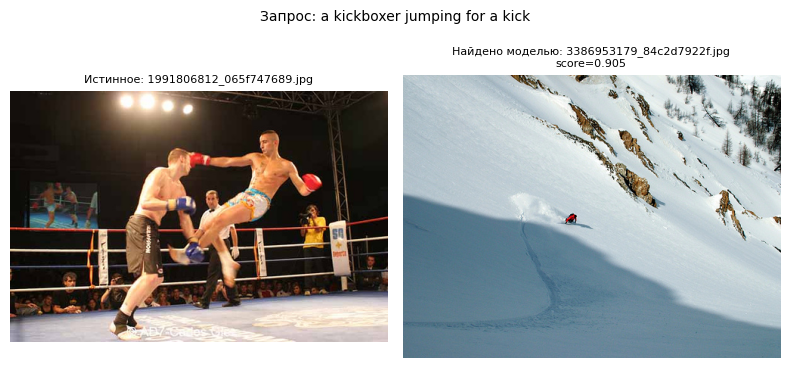

3/3 [==============================] - 0s 3ms/step


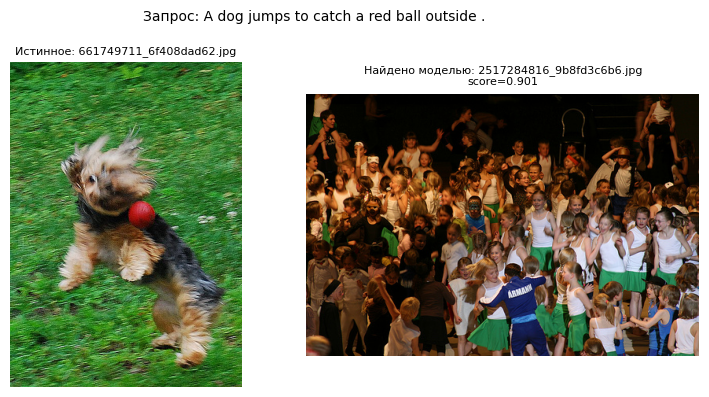

3/3 [==============================] - 0s 2ms/step


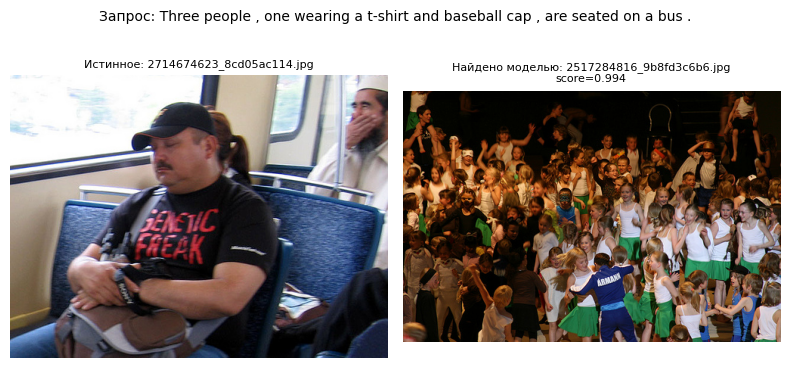

3/3 [==============================] - 0s 4ms/step


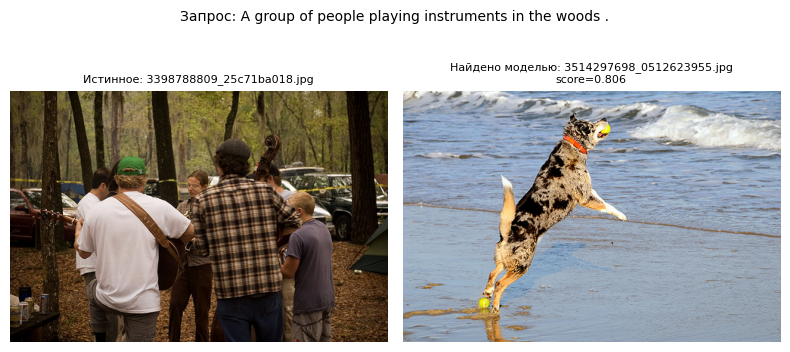

3/3 [==============================] - 0s 3ms/step


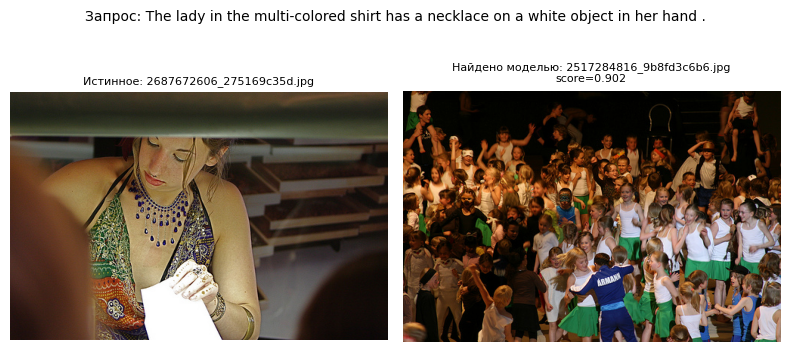

3/3 [==============================] - 0s 4ms/step


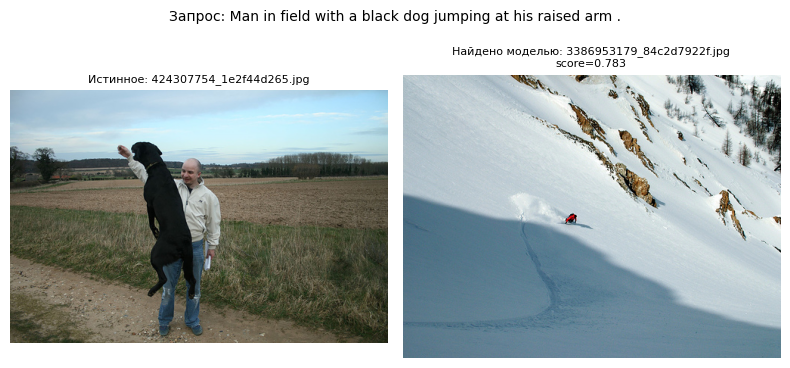

3/3 [==============================] - 0s 3ms/step


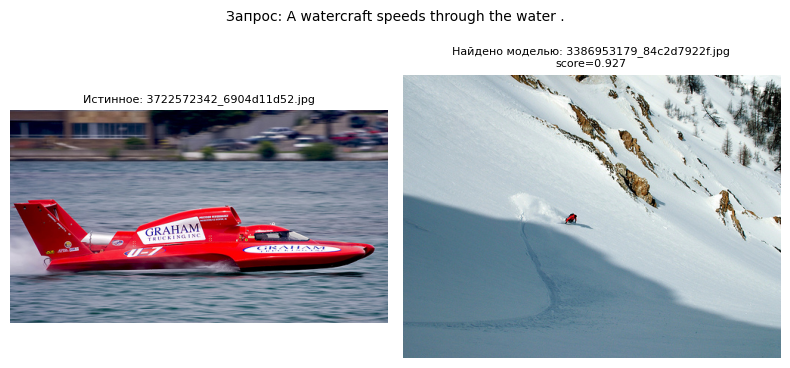

3/3 [==============================] - 0s 3ms/step


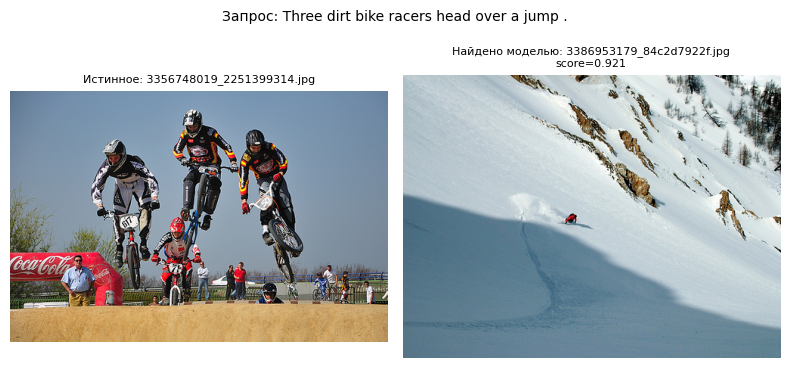

3/3 [==============================] - 0s 3ms/step


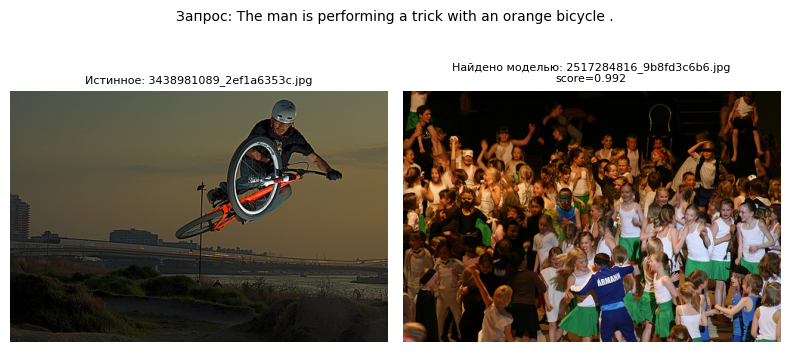

3/3 [==============================] - 0s 5ms/step


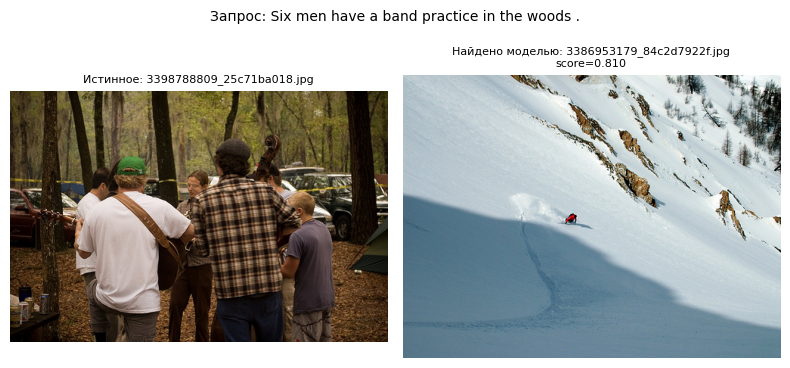

In [59]:
# Тестирование поиска на 10 случайных запросах


test_img_dir = "/Users/kiradejko/SB5/test_images/"

# 10 случайных запросов
sample = test_queries_clean.sample(10, random_state=42).reset_index(drop=True)

for _, row in sample.iterrows():
    query_text = row['query_text']
    true_image_name = row['image']

    # ищем лучшую картинку по FCNN
    pred_imgs, pred_scores = search_best_images(
        model_fcnn,
        query_text,
        tfidf,
        test_img_df,
        scaler,
        top_k=1,
        model_type='keras'
    )
    pred_image_name = pred_imgs[0]

    # загружаем изображения
    true_img_path = os.path.join(test_img_dir, true_image_name)
    pred_img_path = os.path.join(test_img_dir, pred_image_name)

    true_img = Image.open(true_img_path)
    pred_img = Image.open(pred_img_path)

    # визуализация
    plt.figure(figsize=(8, 4))
    plt.suptitle(f"Запрос: {query_text}", fontsize=10)

    plt.subplot(1, 2, 1)
    plt.imshow(true_img)
    plt.title(f"Истинное: {true_image_name}", fontsize=8)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    plt.title(f"Найдено моделью: {pred_image_name}\nscore={pred_scores[0]:.3f}", fontsize=8)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

ВЫВОД. 






## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска